<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/PINN_Inversa_navier_stokes_gput4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.autograd as autograd         #AD, diferenciação automática
from torch import Tensor
import torch.nn as nn                     #rede neural
import torch.optim as optim               #otimizadores
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
import numpy as np
import time
import scipy.io

#Padronizando o tipo dos valores
torch.set_default_dtype(torch.float)
torch.manual_seed(1234) #Uma semente para os valores, evitando a geração aleatória
np.random.seed(1234)

#Esse aqui não sei bem, mas sempre usam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda


In [ ]:
class RNA(nn.Module):
    def __init__(self,camadas):
        super().__init__()

        #Função de ativação
        self.ativacao = nn.Tanh()

        #Criando a rede neural
        self.linears = nn.ModuleList([nn.Linear(camadas[i], camadas[i+1]) for i in range(len(camadas)-1)])

        #inicialização normal
        for i in range(len(camadas)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)


    #propagação direta
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        #Normalizando os dados
        x = (x - l_b)/(u_b - l_b)

        a = x.float()

        for i in range(len(camadas)-2):

            z = self.linears[i](a)
            a = self.ativacao(z)

        a = self.linears[-1](a)
        return a

In [ ]:
#Classe da pinn para navier stokes
class PINN_NS():
  def __init__(self, camadas, x, y, t, u, v, p, X_real):

    self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    self.y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True).to(device)

    self.u = torch.tensor(u, dtype=torch.float32, requires_grad=True).to(device)
    self.v = torch.tensor(v, dtype=torch.float32, requires_grad=True).to(device)
    self.p = torch.tensor(p, dtype=torch.float32, requires_grad=True).to(device)

    self.x_real = torch.tensor(X_real[:,0:1], dtype=torch.float32, requires_grad=True).to(device)
    self.y_real = torch.tensor(X_real[:,1:2], dtype=torch.float32, requires_grad=True).to(device)
    self.t_real = torch.tensor(X_real[:,2:3], dtype=torch.float32, requires_grad=True).to(device)

    self.mse = nn.MSELoss(reduction = 'mean') #Mean Squared Error, tirado do próprio pytorch
    self.itr = 0 #Contador de iteração

    self.lambda_1 = torch.tensor([lambda_1], requires_grad=True).float().to(device)
    self.lambda_2 = torch.tensor([lambda_2], requires_grad=True).float().to(device)

    self.lambda_1 = nn.Parameter(self.lambda_1) #Colocando os lambdas como parametro do pytorch (https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter)
    self.lambda_2 = nn.Parameter(self.lambda_2)

    self.modelo = RNA(camadas).to(device) #Instanciando a rede neural
    self.modelo.register_parameter('lambda_1', self.lambda_1) #Agora está setando os lambdas como parametro da rede neural (https://pytorch.org/docs/stable/generated/torch.nn.Module.html)
    self.modelo.register_parameter('lambda_2', self.lambda_2)

    self.otimizador = optim.LBFGS(self.modelo.parameters(), lr=0.01, max_iter=200000, max_eval=50000,history_size=50,
                                  tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,line_search_fn="strong_wolfe")

  def EDP(self):
    lambda_1 = self.lambda_1
    lambda_2 = self.lambda_2

    psi_p = self.modelo(torch.hstack((self.x, self.y, self.t)))
    psi, p = psi_p[:, 0:1], psi_p[:, 1:2]

    u = autograd.grad(psi, self.y, torch.ones_like(psi), create_graph=True)[0]
    v = -1.*autograd.grad(psi, self.x, torch.ones_like(psi), create_graph=True)[0]

    u_x = autograd.grad(u, self.x, torch.ones_like(u), create_graph = True)[0]
    u_xx = autograd.grad(u_x, self.x, torch.ones_like(u_x), create_graph = True)[0]

    u_y = autograd.grad(u, self.y, torch.ones_like(u), create_graph = True)[0]
    u_yy = autograd.grad(u_y, self.y, torch.ones_like(u_y), create_graph = True)[0]

    u_t = autograd.grad(u, self.t, torch.ones_like(u), create_graph = True)[0]

    v_x = autograd.grad(v, self.x, torch.ones_like(v), create_graph = True)[0]
    v_xx = autograd.grad(v_x, self.x, torch.ones_like(v_x), create_graph = True)[0]

    v_y = autograd.grad(v, self.y, torch.ones_like(v), create_graph = True)[0]
    v_yy = autograd.grad(v_y, self.y, torch.ones_like(v_y), create_graph = True)[0]

    v_t = autograd.grad(v, self.t, torch.ones_like(v), create_graph = True)[0]

    p_x = autograd.grad(p, self.x, torch.ones_like(p), create_graph = True)[0]
    p_y = autograd.grad(p, self.y, torch.ones_like(p), create_graph = True)[0]


    f = u_t + (lambda_1)*(u*u_x + v*u_y) + p_x - (lambda_2)*(u_xx + u_yy)
    g = v_t + (lambda_1)*(u*v_x + v*v_y) + p_y - (lambda_2)*(v_xx + v_yy)

    return u, v, p, f, g

  def erro(self):

    u_pred, v_pred, p_pred, f, g = self.EDP()

    #Erro dos dados
    erro_u = self.mse(u_pred, self.u)
    erro_v = self.mse(v_pred, self.v)
    erro_p = self.mse(p_pred, self.p)

    #Erro da edp
    erro_f = self.mse(f, torch.zeros_like(f))
    erro_g = self.mse(g, torch.zeros_like(g))

    #Erro total
    erro_total = 0.7*erro_u + 0.7.*erro_v + erro_f + erro_g + 0.7*erro_p

    return erro_total

  def treino_otimizador(self):

    self.otimizador.zero_grad()

    erro_total = self.erro()
    erro_total.backward()

    self.itr +=1

    if self.itr % 10 == 0:
      print('Iteração: {:}, Custo: {:0.6f}, 𝜆_PINN = {:.5f},  {:.5f}'.format(self.itr, erro_total, self.lambda_1.item(), self.lambda_2.item()))

    return erro_total

  def treino(self):
    self.otimizador.step(self.treino_otimizador)

  def teste(self):

    u_pred = self.modelo(torch.hstack((self.x_real, self.y_real, self.t_real)))
    #u_pred = u_pred.detach().cpu().numpy()

    psi, p = u_pred[:, 0:1], u_pred[:, 1:2]
    u = autograd.grad(psi, self.y_real, torch.ones_like(psi), create_graph=True)[0]
    v = -1.*autograd.grad(psi, self.x_real, torch.ones_like(psi), create_graph=True)[0]
    error_vec = torch.linalg.norm((U_real-u),2)/torch.linalg.norm(U_real,2)
    error_vec += torch.linalg.norm((V_real-v),2)/torch.linalg.norm(V_real,2)
    error_vec += torch.linalg.norm((P_real-u),2)/torch.linalg.norm(P_real,2)

    return error_vec, u, v, p

In [ ]:
#Inicialização dos parâmetros
lambda_1 = 0.0
lambda_2 = 0.0

In [ ]:
N_train = 1500

dados = scipy.io.loadmat('cylinder_nektar_wake.mat')

U_star = dados['U_star']  # N x 2 x T
P_star = dados['p_star']  # N x T
t_star = dados['t']  # T x 1
X_star = dados['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]


XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]
p_train = p[idx, :]

lb = np.hstack((np.min(x_train), np.min(y_train), np.min(t_train)))
ub = np.hstack((np.max(x_train), np.max(y_train), np.max(t_train)))

X_real = np.hstack((XX.T.flatten()[:, None], YY.T.flatten()[:, None], TT.T.flatten()[:, None]))
P_real = P_star.flatten('F')[:, None]
U_real = UU.T.flatten('F')[:, None]
V_real = VV.T.flatten('F')[:, None]

X_real = torch.tensor(X_real, dtype=torch.float32, requires_grad=True).to(device)
P_real = torch.tensor(P_real, dtype=torch.float32, requires_grad=True).to(device)
U_real = torch.tensor(U_real, dtype=torch.float32, requires_grad=True).to(device)
V_real = torch.tensor(V_real, dtype=torch.float32, requires_grad=True).to(device)

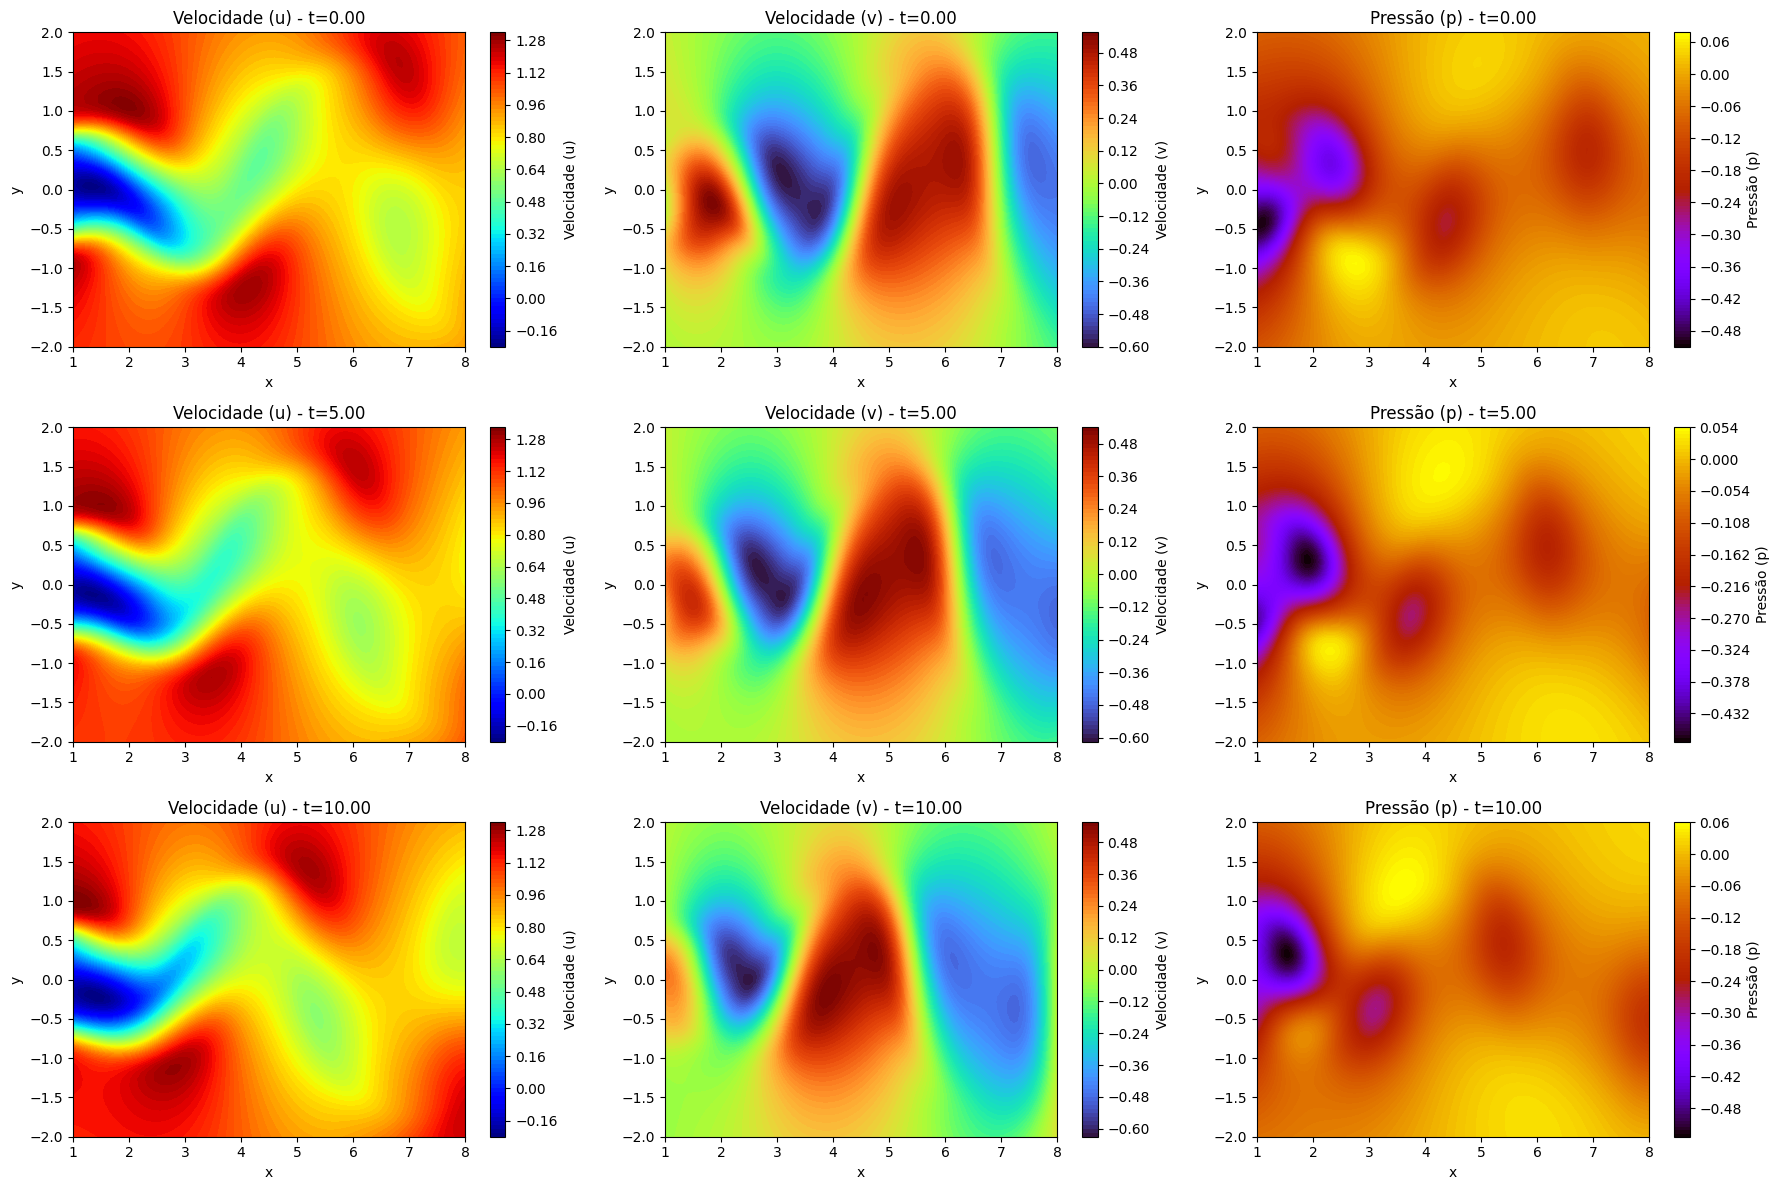

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Parâmetros
# Indices correspondentes a t = 0, t = 5 e t = 10
time_indices = [0, 50, 100]

# Função para determinar dimensões da grade 2D
def infer_grid_dimensions(X_star):
    x_unique = np.unique(X_star[:, 0])
    y_unique = np.unique(X_star[:, 1])
    nx, ny = len(x_unique), len(y_unique)
    return nx, ny, x_unique, y_unique

# Determinar dimensões da grade
nx, ny, x_unique, y_unique = infer_grid_dimensions(X_star)

# Coordenadas da grade 2D
x_grid, y_grid = np.meshgrid(x_unique, y_unique)

# Função para preparar dados em formato 2D
def prepare_data(data, time_idx, nx, ny):
    return data[:, time_idx].reshape(ny, nx)

# Loop sobre os instantes de tempo para plotagem
fig, axs = plt.subplots(len(time_indices), 3, figsize=(18, 4 * len(time_indices)))

for i, t_idx in enumerate(time_indices):
    # Preparar os campos
    u_field = prepare_data(UU, t_idx, nx, ny)
    v_field = prepare_data(VV, t_idx, nx, ny)
    p_field = prepare_data(PP, t_idx, nx, ny)

    # Plotar campo u
    ax = axs[i, 0]
    c = ax.contourf(x_grid, y_grid, u_field, levels=100, cmap='jet')
    fig.colorbar(c, ax=ax, label='Velocidade (u)')
    ax.set_title(f'Velocidade (u) - t={t_star[t_idx, 0]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Plotar campo v
    ax = axs[i, 1]
    c = ax.contourf(x_grid, y_grid, v_field, levels=100, cmap='turbo')
    fig.colorbar(c, ax=ax, label='Velocidade (v)')
    ax.set_title(f'Velocidade (v) - t={t_star[t_idx, 0]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Plotar campo p
    ax = axs[i, 2]
    c = ax.contourf(x_grid, y_grid, p_field, levels=100, cmap='gnuplot')
    fig.colorbar(c, ax=ax, label='Pressão (p)')
    ax.set_title(f'Pressão (p) - t={t_star[t_idx, 0]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()


In [ ]:
itr=20000
lr=0.1
camadas = np.array([3,20,20,20,20,20,20,20,20,2]) #2 nós de entradas, 8 camadas ocultas contendo 20 nós por camadas e uma saída
N_u = 100 #Número total de pontos de dados para 'u'
N_f = 25000 # Número total de pontos de colocação
nu = 0.01/np.pi #Coeficiente de difusão

In [ ]:
pinn_ns = PINN_NS(camadas, x_train, y_train, t_train, u_train, v_train, p_train, X_real)

pinn_ns.treino()

<ipython-input-3-81f877ca112f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_real = torch.tensor(X_real[:,0:1], dtype=torch.float32, requires_grad=True).to(device)
<ipython-input-3-81f877ca112f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_real = torch.tensor(X_real[:,1:2], dtype=torch.float32, requires_grad=True).to(device)
<ipython-input-3-81f877ca112f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_real = torch.tensor(X_real[:,2:3], dtype=torch.float32, requires_grad=True).to(device)


Iteração: 10, Custo: 0.912437, 𝜆_PINN = 0.00000,  -0.00000
Iteração: 20, Custo: 0.423931, 𝜆_PINN = -0.00001,  -0.00008
Iteração: 30, Custo: 0.256850, 𝜆_PINN = -0.00043,  -0.00027
Iteração: 40, Custo: 0.217749, 𝜆_PINN = -0.00061,  0.00027
Iteração: 50, Custo: 0.174213, 𝜆_PINN = -0.00025,  0.00363
Iteração: 60, Custo: 0.163917, 𝜆_PINN = 0.00022,  0.00699
Iteração: 70, Custo: 0.159591, 𝜆_PINN = 0.00037,  0.00898
Iteração: 80, Custo: 0.154779, 𝜆_PINN = 0.00049,  0.01123
Iteração: 90, Custo: 0.147918, 𝜆_PINN = 0.00083,  0.01398
Iteração: 100, Custo: 0.144537, 𝜆_PINN = 0.00115,  0.01648
Iteração: 110, Custo: 0.140485, 𝜆_PINN = 0.00145,  0.01603
Iteração: 120, Custo: 0.138999, 𝜆_PINN = 0.00157,  0.01389
Iteração: 130, Custo: 0.138042, 𝜆_PINN = 0.00176,  0.01331
Iteração: 140, Custo: 0.136635, 𝜆_PINN = 0.00235,  0.01487
Iteração: 150, Custo: 0.135194, 𝜆_PINN = 0.00289,  0.01581
Iteração: 160, Custo: 0.132766, 𝜆_PINN = 0.00346,  0.01509
Iteração: 170, Custo: 0.131288, 𝜆_PINN = 0.00318,  0.01203

In [ ]:
error_vec, u, v, p = pinn_ns.teste()

print('Erro total: {:.5f}'.format(error_vec))

Erro total: 9.29128


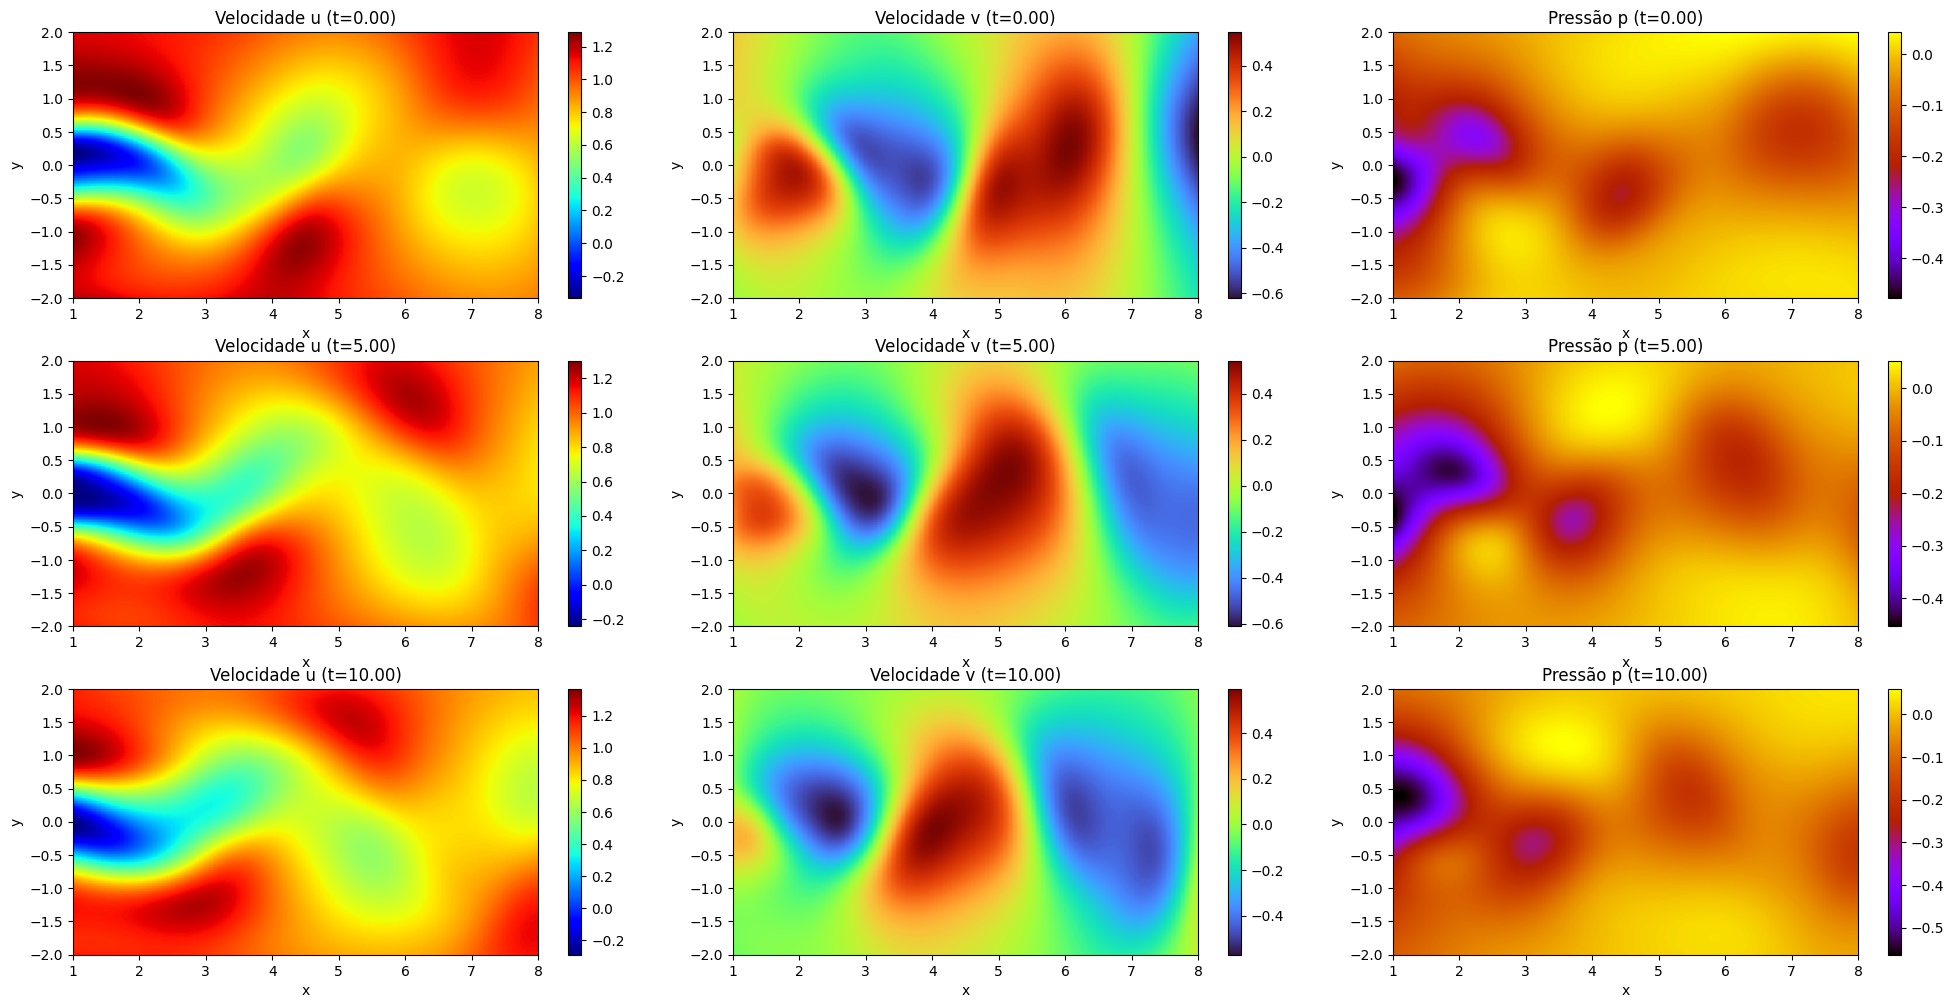

In [ ]:
def plot_campos(pinn, x, y, t_values, nx, ny):
    """
    Plota os campos de u, v e p em diferentes momentos.

    Args:
        pinn: Instância do modelo PINN_NS.
        x: Coordenadas x (array numpy).
        y: Coordenadas y (array numpy).
        t_values: Lista de momentos de tempo para avaliação.
        nx: Número de pontos no eixo x.
        ny: Número de pontos no eixo y.
    """
    # Geração da malha
    x_grid, y_grid = np.meshgrid(x, y)
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()

    # Criação da figura para os subplots
    fig, axes = plt.subplots(len(t_values), 3, figsize=(20, 10))

    for i, t in enumerate(t_values):
        # Criar tensores com requires_grad=True
        x_tensor = torch.tensor(x_flat, dtype=torch.float32, requires_grad=True).to(device)
        y_tensor = torch.tensor(y_flat, dtype=torch.float32, requires_grad=True).to(device)
        t_tensor = torch.full_like(x_tensor, fill_value=t, dtype=torch.float32, requires_grad=True).to(device)

        # Combinar entradas
        input_tensor = torch.stack((x_tensor, y_tensor, t_tensor), dim=1)

        # Passar pelo modelo
        psi_p = pinn.modelo(input_tensor)
        psi, p = psi_p[:, 0:1], psi_p[:, 1:2]

        # Calcular as velocidades u e v
        u = torch.autograd.grad(psi, y_tensor, torch.ones_like(psi), create_graph=True)[0].detach().cpu().numpy().reshape((ny, nx))
        v = -torch.autograd.grad(psi, x_tensor, torch.ones_like(psi), create_graph=True)[0].detach().cpu().numpy().reshape((ny, nx))
        p = p.detach().cpu().numpy().reshape((ny, nx))

        # Plotar os resultados
        im1 = axes[i, 0].imshow(u, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='jet')
        axes[i, 0].set_title(f"Velocidade u (t={t:.2f})")
        axes[i, 0].set_xlabel("x")
        axes[i, 0].set_ylabel("y")
        fig.colorbar(im1, ax=axes[i, 0])

        im2 = axes[i, 1].imshow(v, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='turbo')
        axes[i, 1].set_title(f"Velocidade v (t={t:.2f})")
        axes[i, 1].set_xlabel("x")
        axes[i, 1].set_ylabel("y")
        fig.colorbar(im2, ax=axes[i, 1])

        im3 = axes[i, 2].imshow(p, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='gnuplot')
        axes[i, 2].set_title(f"Pressão p (t={t:.2f})")
        axes[i, 2].set_xlabel("x")
        axes[i, 2].set_ylabel("y")
        fig.colorbar(im3, ax=axes[i, 2])

    plt.tight_layout()
    plt.show()

# Exemplo de uso
x = np.linspace(1, 8, 100)
y = np.linspace(-2, 2, 100)
t_values = [0.0, 5., 10.0]  # Momentos de tempo
nx, ny = len(x), len(y)

plot_campos(pinn=pinn_ns, x=x, y=y, t_values=t_values, nx=nx, ny=ny)


GIF salvo como 'campos_temporais.gif'.


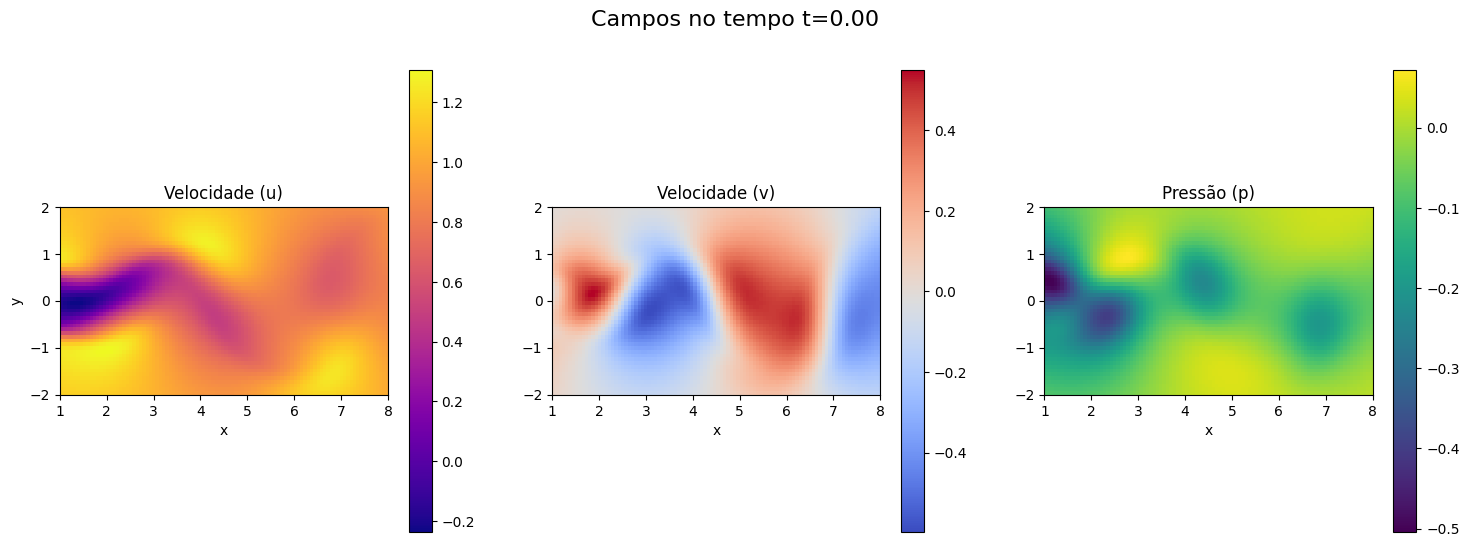

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# Função para preparar os dados no formato 2D (grid)
def prepare_data(data, time_idx, nx, ny):
    return data[:, time_idx].reshape((ny, nx))

# Função para calcular as dimensões da grade (nx, ny)
def infer_grid_dimensions(X_star):
    x_unique = np.unique(X_star[:, 0])
    y_unique = np.unique(X_star[:, 1])
    nx = len(x_unique)
    ny = len(y_unique)
    return nx, ny, x_unique, y_unique

# Determinar dimensões da grade
nx, ny, x_unique, y_unique = infer_grid_dimensions(X_star)

# Coordenadas da grade 2D
x_grid, y_grid = np.meshgrid(x_unique, y_unique)

# Criar figura e subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Campos no tempo t=0.00', fontsize=16)

# Inicializar subplots para u, v e p
u_field = prepare_data(UU, 0, nx, ny)
v_field = prepare_data(VV, 0, nx, ny)
p_field = prepare_data(PP, 0, nx, ny)

im1 = axes[0].imshow(u_field, cmap='plasma', extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()])
axes[0].set_title('Velocidade (u)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(v_field, cmap='coolwarm', extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()])
axes[1].set_title('Velocidade (v)')
axes[1].set_xlabel('x')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(p_field, cmap='viridis', extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()])
axes[2].set_title('Pressão (p)')
axes[2].set_xlabel('x')
plt.colorbar(im3, ax=axes[2])

# Função para atualizar os frames
def update_frame(t_idx):
    u_field = prepare_data(UU, t_idx, nx, ny)
    v_field = prepare_data(VV, t_idx, nx, ny)
    p_field = prepare_data(PP, t_idx, nx, ny)

    # Atualizar as imagens
    im1.set_array(u_field)
    im2.set_array(v_field)
    im3.set_array(p_field)

    # Atualizar o título
    fig.suptitle(f'Campos no tempo t={t_star[t_idx, 0]:.2f}', fontsize=16)

# Criar a animação
anim = FuncAnimation(fig, update_frame, frames=T, interval=200, repeat=True)

# Salvar o GIF
writer = PillowWriter(fps=10)
anim.save("campos_temporais.gif", writer=writer)

print("GIF salvo como 'campos_temporais.gif'.")

In [ ]:
#Classe da pinn para navier stokes
class PINN_NS():
  def __init__(self, camadas, x, uw, uo, uw0, uo0, X_real):

    self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)

    self.uw = torch.tensor(uw, dtype=torch.float32, requires_grad=True).to(device)
    self.uo = torch.tensor(uo, dtype=torch.float32, requires_grad=True).to(device)

    self.uw0 = torch.tensor(uw0, dtype=torch.float32, requires_grad=True).to(device)
    self.uo0 = torch.tensor(uo0, dtype=torch.float32, requires_grad=True).to(device)

    self.x_real = torch.tensor(X_real, dtype=torch.float32, requires_grad=True).to(device)

    self.mse = nn.MSELoss(reduction = 'mean') #Mean Squared Error, tirado do próprio pytorch
    self.itr = 0 #Contador de iteração

    self.modelo = RNA(camadas).to(device) #Instanciando a rede neural

    self.otimizador = optim.LBFGS(self.modelo.parameters(), lr=0.01, max_iter=200000, max_eval=50000,history_size=50,
                                  tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,line_search_fn="strong_wolfe")

  def EDP(self):
    uwuo = self.modelo(self.x)
    uw_pred, uo_pred = uwuo[:, 0:1], uwuo[:, 1:2]

    uw_x = autograd.grad(uw_pred, self.x, torch.ones_like(uw_pred), create_graph = True)[0]
    uo_x = autograd.grad(uo_pred, self.x, torch.ones_like(uo_pred), create_graph = True)[0]


    f = 1.*uw_x + termofonte
    g = 1.*uo_x - termofonte

    return uw_pred, uo_pred, f, g

  def erro(self):

    uw_pred, uo_pred, f, g = self.EDP()

    #Erro dos dados
    erro_uo0 = self.mse(self.modelo(self.x0))
    #Erro da edp
    erro_f = self.mse(f, torch.zeros_like(f))
    erro_g = self.mse(g, torch.zeros_like(g))

    #Erro total
    erro_total = erro_u + erro_v + erro_f + erro_g + erro_p

    return erro_total

  def treino_otimizador(self):

    self.otimizador.zero_grad()

    erro_total = self.erro()
    erro_total.backward()

    self.itr +=1

    if self.itr % 10 == 0:
      print('Iteração: {:}, Custo: {:0.6f}, 𝜆_PINN = {:.5f},  {:.5f}'.format(self.itr, erro_total, self.lambda_1.item(), self.lambda_2.item()))

    return erro_total

  def treino(self):
    self.otimizador.step(self.treino_otimizador)

  def teste(self):

    u_pred = self.modelo(torch.hstack((self.x_real, self.y_real, self.t_real)))
    #u_pred = u_pred.detach().cpu().numpy()

    psi, p = u_pred[:, 0:1], u_pred[:, 1:2]
    u = autograd.grad(psi, self.y_real, torch.ones_like(psi), create_graph=True)[0]
    v = -1.*autograd.grad(psi, self.x_real, torch.ones_like(psi), create_graph=True)[0]
    error_vec = torch.linalg.norm((U_real-u),2)/torch.linalg.norm(U_real,2)
    error_vec += torch.linalg.norm((V_real-v),2)/torch.linalg.norm(V_real,2)
    error_vec += torch.linalg.norm((P_real-u),2)/torch.linalg.norm(P_real,2)

    return error_vec, u, v, p